## Improving Water Consumption Management in Barcelona through Data Quality Enhancement and Prediction Models
#### **TFG 2023-2024**
#### **Author: Edith Ruiz Macià**

### Analysis of dataset Dataset1_activitat_eco_v2.csv

### **About the Notebook**

The aim of this notebook (.ipynb) is to analyze and modify the dataset dataset1_activitat_eco_v2.csv provided by Aigües de Barcelona in order to improve the quality of the data and learn its insights through its visualization.

#### ***How to execute the code***
This is a Python Notebook, so the code should be run either cell by cell or by running all the notebook at once. At the beginning, review and make sure the paths to all datasets are correct for your folders distribution in order for everything to run smoothly.


#### ***Libraries and packages used in the project***
1. **pandas:** Library for data manipulation and analysis. It is used to work with data structures such as DataFrames.
2. **matplotlib.pyplot:** Used to create graphs and visualizations.
3. **matplotlib.dates:** Used to create graphs and visualizations.
4. **numpy:** Fundamental library for numerical computation.
5. **seaborn:** Data visualization library based on Matplotlib. It provides a high-level interface for drawing attractive statistical graphs.
6. **sklearn.preprocessing:** Provides functions to preprocess data before fitting a model.
7. **sklearn.model_selection:** Provides tools to split data sets into training and test subsets for a model.
8. **sklearn.metrics:** Contains metrics for evaluating models.
9. **sklearn.feature_selection:** Library to select the best features for training a model.
10. **sklearn.linear_model**: Contains implementations of linear regression models.
11. **sklearn.ensemble:** Contains implementations of ensemble models such as Random Forest.
12. **xgboost:** Library to implement Gradient Boosting models.
13. **sklearn.neighbors:** Library to implement K-Nearest Neighbors models.
14. **sklearn.svm:** Library to implement Support Vector Machine models.
15. **shap:** Library used to compute the shap values of a model and model explainability.

In [1]:
# In case you are working in google colab you can mount your google drive account here
# from google.colab import drive
# drive.mount('/content/drive')

## 0. Importing datasets and libraries

In [2]:
!pip install shap

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
# Change your path of the data if necessary
dataset_1_act_eco = 'C:/Users/edith/Desktop/TFG/Datasets/Aigües de Barcelona/Sets-de-dades/dataset1_activitat_eco_v2.csv'
dataset_1_act_eco = pd.read_csv(dataset_1_act_eco)
dataset_1_act_eco.head()

,Districte/Distrito/District,Codi postal/Código postal/Postcode,Municipi/Municipio/Municipality,Data/Fecha/Date,Ús/Uso/Use,Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity,Nombre de comptadors/Número de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0


## 1. Exploratory Data Analysis

As a starting point, we need to explore the data. We analyze the summary of descriptive statistics and plots for each of the datasets in order to detect the corresponding anomalies and subsequently process them correctly.

In [5]:
dataset_1_act_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20495388 entries, 0 to 20495387
Data columns (total 8 columns):
 #   Column                                                                             Dtype  
---  ------                                                                             -----  
 0   Districte/Distrito/District                                                        float64
 1   Codi postal/Código postal/Postcode                                                 int64  
 2   Municipi/Municipio/Municipality                                                    object 
 3   Data/Fecha/Date                                                                    object 
 4   Ús/Uso/Use                                                                         object 
 5   Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity  object 
 6   Nombre de comptadors/Número de contadores/Number of meters                         int64  
 7   Consum acumulat (

In [6]:
dataset_1_act_eco.describe()

,Districte/Distrito/District,Codi postal/Código postal/Postcode,Nombre de comptadors/Número de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)
count,2.019081e+07,2.049539e+07,2.049539e+07,2.049539e+07
mean,4.109745e+00,8.255526e+03,3.539717e+00,2.048457e+03
std,2.840611e+00,3.930091e+02,1.087388e+01,2.060644e+05
min,1.000000e+00,8.001000e+03,1.000000e+00,-4.154402e+08
25%,2.000000e+00,8.013000e+03,1.000000e+00,2.500000e+01
50%,3.000000e+00,8.026000e+03,1.000000e+00,1.560000e+02
75%,6.000000e+00,8.840000e+03,3.000000e+00,6.470000e+02
max,1.000000e+01,8.980000e+03,3.940000e+02,4.151876e+08


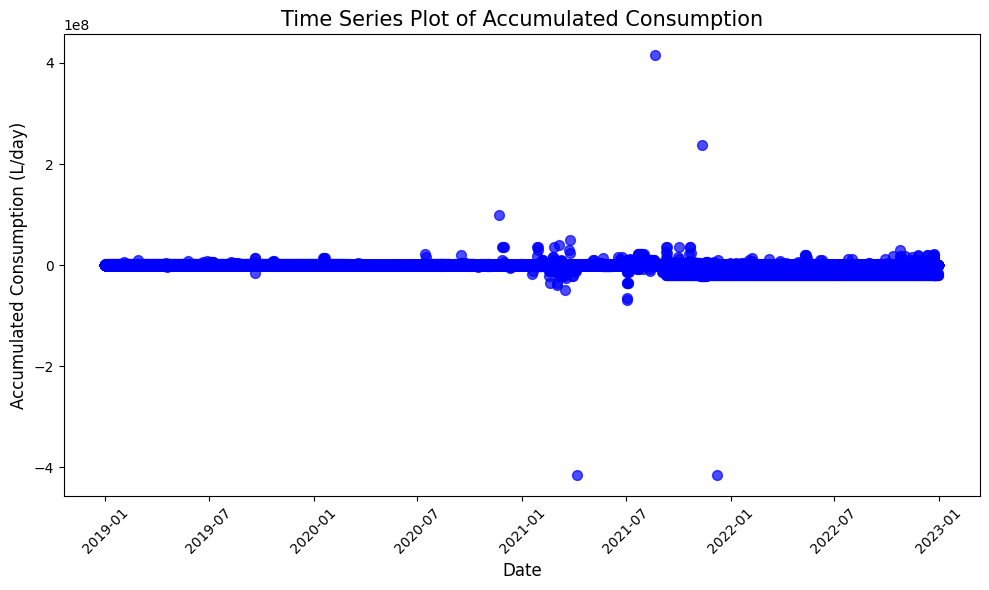

In [7]:
# Accumulated Consumption over Time
dataset_1_act_eco['Data/Fecha/Date'] = pd.to_datetime(dataset_1_act_eco['Data/Fecha/Date'])
plt.figure(figsize=(10, 6))
plt.scatter(dataset_1_act_eco['Data/Fecha/Date'], dataset_1_act_eco['Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)'], color='blue', marker='o', s=50, alpha=0.7, label='Data Points')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accumulated Consumption (L/day)', fontsize=12)
plt.title('Time Series Plot of Accumulated Consumption', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

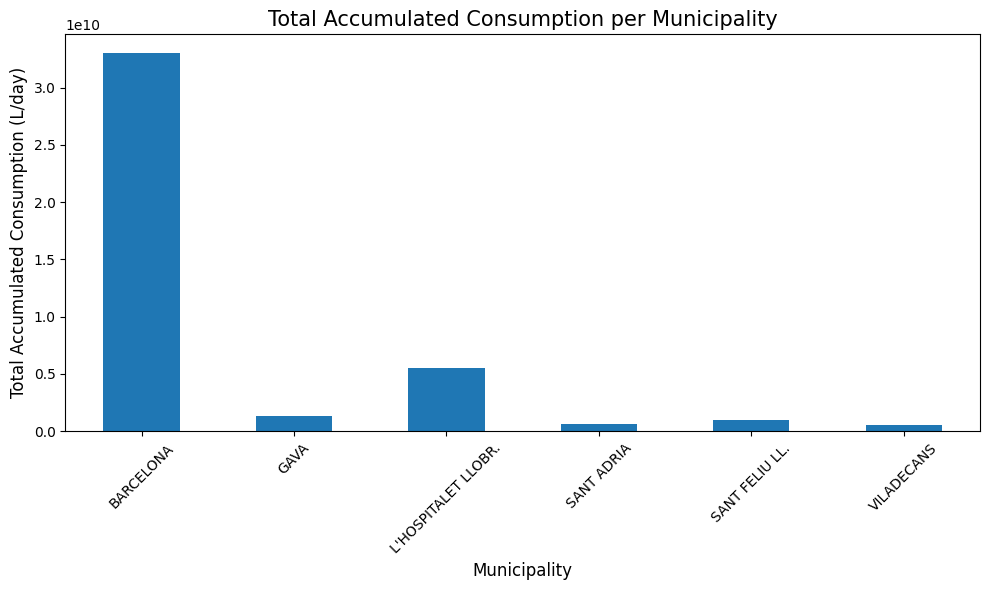

In [8]:
# Aggregate total consumption for each municipality
total_consumption_per_municipality = dataset_1_act_eco.groupby('Municipi/Municipio/Municipality')['Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)'].sum()
total_consumption_per_municipality.plot(kind='bar', figsize=(10,6))
plt.xlabel('Municipality', fontsize=12)
plt.ylabel('Total Accumulated Consumption (L/day)', fontsize=12)
plt.title('Total Accumulated Consumption per Municipality', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
print("Poscodes of Barcelona:")
print(dataset_1_act_eco[dataset_1_act_eco['Municipi/Municipio/Municipality'] == 'BARCELONA']["Codi postal/Código postal/Postcode"].unique())

Poscodes of Barcelona:
[8001 8002 8003 8004 8005 8006 8007 8008 8009 8010 8011 8012 8013 8014
 8015 8016 8017 8018 8019 8020 8022 8023 8024 8025 8026 8027 8028 8029
 8030 8031 8032 8033 8034 8035 8036 8037 8038 8039 8040 8041 8042 8021]


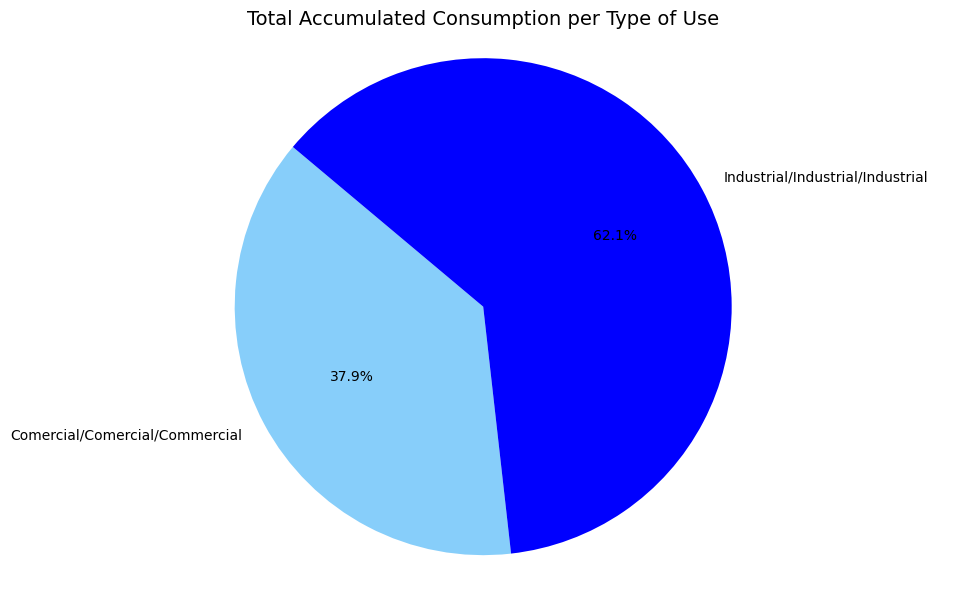

In [10]:
# Aggregate total consumption for each type of use
total_consumption_per_use = dataset_1_act_eco.groupby('Ús/Uso/Use')['Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)'].sum()
plt.figure(figsize=(10, 6))
total_consumption_per_use.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightskyblue', 'blue', 'cornflowerblue'])
plt.title('Total Accumulated Consumption per Type of Use', fontsize=14)
plt.ylabel(None)
plt.tight_layout()
plt.axis('equal')
plt.show()

**Insights:**
- Negative consumption values are considered as incorrect values for the Cumulative Consumption (L/day) column. Consumption has to be positive.
- The number of meters ('Number of meters') varies greatly, with some locations having just one meter and others up to 394 meters.
- In the scatter plot we can clearly see outliers that will be removed later on.
- Most of the consumption is accumulated in the Municipality of Barcelona and it's of Industrial use.

## 2. Data Preprocessing

##### **2.1. Data Transformation**

In [11]:
# Rename dataset_1_activitat_eco_v2 columns
new_column_names = {
    'Districte/Distrito/District': 'District',
    'Codi postal/Código postal/Postcode': 'Postcode',
    'Municipi/Municipio/Municipality': 'Municipality',
    'Data/Fecha/Date': 'Date',
    'Ús/Uso/Use': 'Use',
    "Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity": 'Type of economic activity',
    'Nombre de comptadors/Número de contadores/Number of meters': 'Number of meters',
    'Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)': 'Accumulated Consumption (L/day)'
}

dataset_1_act_eco.rename(columns=new_column_names, inplace=True)

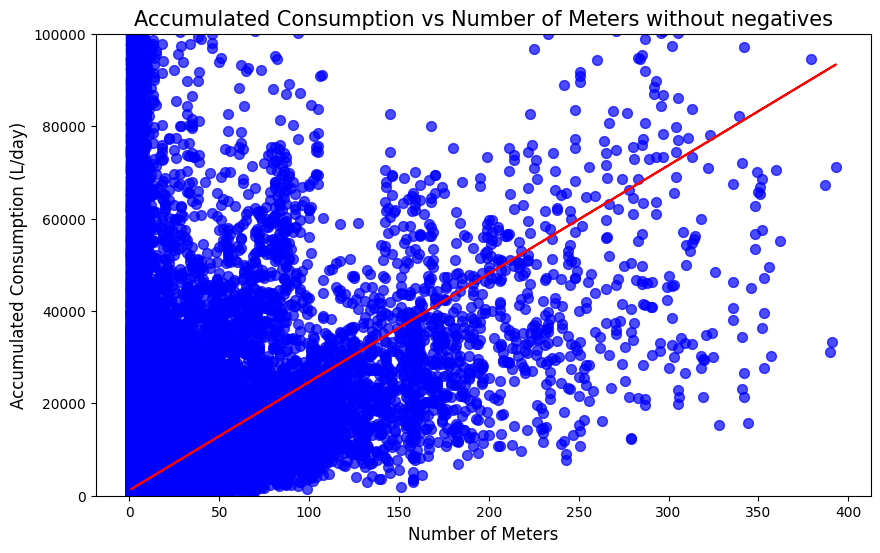

In [12]:
# Randomly sample 700000 data points
sampled_indices = np.random.choice(len(dataset_1_act_eco), size=700000, replace=False)
sampled_data = dataset_1_act_eco.iloc[sampled_indices]

# Scatter Plot for Accumulated Consumption vs Number of Meters without negatives
plt.figure(figsize=(10, 6))
plt.scatter(sampled_data['Number of meters'], sampled_data['Accumulated Consumption (L/day)'], color='blue', marker='o', s=50, alpha=0.7, label='Data Points')
plt.title('Accumulated Consumption vs Number of Meters without negatives', fontsize=15)
plt.xlabel('Number of Meters', fontsize=12)
plt.ylabel('Accumulated Consumption (L/day)', fontsize=12)
plt.ylim(0, 100000)

# Calculate the trend line
x = sampled_data['Number of meters']
y = sampled_data['Accumulated Consumption (L/day)']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()

We cannot assure that consumption is not normalized, but according to the plots above it does not look like it therefore, they have to be normalized. We will divide the Accumulated Consumption by the Number of Meters in order to obtain the Accumulated Consumption for a single Meter.

In [13]:
# Normalization of Accumulated Consumption (L/day) by Number of meters
dataset_1_act_eco['Normalized Accumulated Consumption (L/day)'] = round(dataset_1_act_eco['Accumulated Consumption (L/day)'] / dataset_1_act_eco['Number of meters'], 3)
dataset_1_act_eco.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0,1.0
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0,84.0
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0,134.0


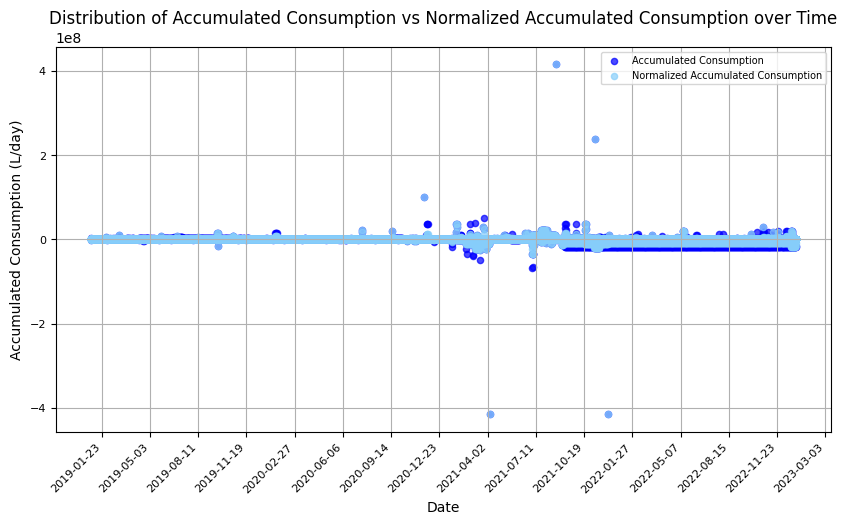

In [14]:
# Distribution of normalized vs non normalized
plt.figure(figsize=(10, 5))
plt.scatter(dataset_1_act_eco["Date"], dataset_1_act_eco["Accumulated Consumption (L/day)"], color='blue',  marker='o', s=20, alpha=0.7, label='Accumulated Consumption')
plt.scatter(dataset_1_act_eco["Date"], dataset_1_act_eco["Normalized Accumulated Consumption (L/day)"], color='lightskyblue',  marker='o', s=20, alpha=0.7, label='Normalized Accumulated Consumption')
plt.title("Distribution of Accumulated Consumption vs Normalized Accumulated Consumption over Time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Accumulated Consumption (L/day)", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.show()

In [15]:
dataset_1_act_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20495388 entries, 0 to 20495387
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   District                                    float64       
 1   Postcode                                    int64         
 2   Municipality                                object        
 3   Date                                        datetime64[ns]
 4   Use                                         object        
 5   Type of economic activity                   object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.4+ GB


##### **2.2. Null Values**

In [16]:
# Null values per column
columns_dataset_1_act_eco = dataset_1_act_eco.columns
for column in columns_dataset_1_act_eco:
  print("Column:", column, "- Null values: ", dataset_1_act_eco[column].isnull().sum())

Column: District - Null values:  304581
Column: Postcode - Null values:  0
Column: Municipality - Null values:  0
Column: Date - Null values:  0
Column: Use - Null values:  0
Column: Type of economic activity - Null values:  0
Column: Number of meters - Null values:  0
Column: Accumulated Consumption (L/day) - Null values:  0
Column: Normalized Accumulated Consumption (L/day) - Null values:  0


##### **2.3. Wrong Values**

Now we want to identify the erroneous values in our data. We consider as wrong values the negative consumptions. We will store those values for later analysis.

In [17]:
# We identify negative values in consumption
num_negative_consum_rows = len(dataset_1_act_eco[dataset_1_act_eco['Normalized Accumulated Consumption (L/day)'] < 0])
print("Negative in 'Accumulated Consumption (L/day)' in the dataset:", num_negative_consum_rows)

Negative in 'Accumulated Consumption (L/day)' in the dataset: 32591


In [18]:
# Copy the negative values into the anomalies dataset for later analysis
anomalies = dataset_1_act_eco[dataset_1_act_eco['Normalized Accumulated Consumption (L/day)'] < 0].copy()
anomalies.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
3589,NaN,8001,BARCELONA,2021-05-31,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
3926,NaN,8001,BARCELONA,2021-07-18,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
3942,NaN,8001,BARCELONA,2021-07-20,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
4022,NaN,8001,BARCELONA,2021-07-30,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
4102,NaN,8001,BARCELONA,2021-08-09,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0


In [19]:
# Replace negative values in Normalized Accumulated Consumption (L/day) by null
dataset_1_act_eco_1 = dataset_1_act_eco.copy()
dataset_1_act_eco_1.loc[dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'] < 0, 'Normalized Accumulated Consumption (L/day)'] = np.nan

# Let's put null also the values of the Accumulated Consumption (L/day)
dataset_1_act_eco_1.loc[dataset_1_act_eco_1['Accumulated Consumption (L/day)'] < 0, 'Accumulated Consumption (L/day)'] = np.nan

# Number of negative values in Normalized Accumulated Consumption (L/day) after removing negative values
num_negative_consum_rows2 = len(dataset_1_act_eco_1[dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'] < 0])
print("Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset:", num_negative_consum_rows2)

# Number of null values in Normalized Accumulated Consumption (L/day) after removing negative values
print("Number of Nulls in the dataset without negative values:", dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'].isnull().sum())

Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset: 0
Number of Nulls in the dataset without negative values: 32591


##### **2.4. Outliers**

In [20]:
# Treatment of outliers in Normalized Accumulated Consumption (L/day) with the IQR method

# We separate according to USE: Industrial, Domestic or Commercial
domestic_df = dataset_1_act_eco_1[dataset_1_act_eco_1['Use'].str.contains('Domèstic', case=False, na=False)].copy()
industrial_df = dataset_1_act_eco_1[dataset_1_act_eco_1['Use'].str.contains('Industrial', case=False, na=False)].copy()
comercial_df = dataset_1_act_eco_1[dataset_1_act_eco_1['Use'].str.contains('Comercial', case=False, na=False)].copy()

def outliers_iqr(dataframe):
    global anomalies

    # We compute the IQR for the 'Consumption' column
    consum_col = 'Normalized Accumulated Consumption (L/day)'
    Q1 = dataframe[consum_col].quantile(0.25)
    Q3 = dataframe[consum_col].quantile(0.75)
    IQR = Q3 - Q1

    # We identify the outliers
    outlier_filter = ((dataframe[consum_col] < (Q1 - 1.5 * IQR)) | (dataframe[consum_col] > (Q3 + 1.5 * IQR)))

    # Copy the outlier value into the anomalies dataset for later analysis
    outliers = dataframe[outlier_filter].copy()
    anomalies = pd.concat([anomalies, outliers], ignore_index=True)

    # And replace them with null
    dataframe.loc[outlier_filter, consum_col] = np.nan

    return dataframe

# We apply the function for each dataframe corresponding to each "Use"
domestic_df = outliers_iqr(domestic_df)
industrial_df = outliers_iqr(industrial_df)
comercial_df = outliers_iqr(comercial_df)

dataset_1_act_eco_filtered = pd.concat([domestic_df, industrial_df, comercial_df], ignore_index=True)

In [21]:
# Let's put to null also the values that correspond to those outliers in 'Accumulated Consumption (L/day)'
dataset_1_act_eco_filtered.loc[dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull(), 'Accumulated Consumption (L/day)'] = np.nan

In [22]:
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373293 entries, 0 to 2373292
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   District                                    float64       
 1   Postcode                                    int64         
 2   Municipality                                object        
 3   Date                                        datetime64[ns]
 4   Use                                         object        
 5   Type of economic activity                   object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 163.0+ MB


In [23]:
# Number of null values in Normalized Accumulated Consumption (L/day) prior to removing outliers
print("Number of Nulls in the dataset with outliers but no negatives:", dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'].isnull().sum())        #dataset with outliers

# Number of null values in Normalized Accumulated Consumption (L/day) after removing outliers
print("Number of Nulls in the dataset without outliers nor negatives:", dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull().sum())   #dataset without outliers

Number of Nulls in the dataset with outliers but no negatives: 32591
Number of Nulls in the dataset without outliers nor negatives: 2373293


##### **2.5. Storage of Anomalies**

If all anomalies in the data have been cleaned correctly we should have the sum of the number of outlier values and negatives remaining in our anomalies stored.

Negative values removed = 32591

Outliers removed = 2373293 - 32591 = 2340702

Total number of anomalies = 2373293

In [24]:
# Save current clean dataset for classification of anomalies
clean_data = dataset_1_act_eco_filtered.copy()

anomalies.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
0,NaN,8001,BARCELONA,2021-05-31,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
1,NaN,8001,BARCELONA,2021-07-18,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
2,NaN,8001,BARCELONA,2021-07-20,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
3,NaN,8001,BARCELONA,2021-07-30,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
4,NaN,8001,BARCELONA,2021-08-09,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0


## 3. Data Enhancement

In [25]:
# Convert "Date" column to datetime
dataset_1_act_eco_filtered['Date'] = pd.to_datetime(dataset_1_act_eco_filtered['Date'])
dataset_1_act_eco_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20495388 entries, 0 to 20495387
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   District                                    float64       
 1   Postcode                                    int64         
 2   Municipality                                object        
 3   Date                                        datetime64[ns]
 4   Use                                         object        
 5   Type of economic activity                   object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.4+ GB


In [26]:
# We create a new "Season" column based on the "Date" column
def map_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

dataset_1_act_eco_filtered['Season'] = dataset_1_act_eco_filtered['Date'].dt.month.map(map_to_season)

# We create a new column "Day_of_Week" based on the column "Date"
dataset_1_act_eco_filtered['Day of Week'] = dataset_1_act_eco_filtered['Date'].dt.day_name()

# We create a new column "Month" based on the column "Date"
dataset_1_act_eco_filtered['Month'] = dataset_1_act_eco_filtered['Date'].dt.month

# We create a new column "Year" based on the column "Date"
dataset_1_act_eco_filtered['Year'] = dataset_1_act_eco_filtered['Date'].dt.year

dataset_1_act_eco_filtered.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0,1.0,Winter,Tuesday,1,2019
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Tuesday,1,2019
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0,84.0,Winter,Wednesday,1,2019
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Wednesday,1,2019
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0,134.0,Winter,Thursday,1,2019


As we can see now all data in this dataset ranges from years 2019 to 2022. This is important as now we are going to add new information from other datasets and we are going to need the dates to match.

In [27]:
dataset_1_act_eco_filtered['Year'].unique()

array([2019, 2020, 2021, 2022], dtype=int64)

In [28]:
temperature = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Temperature_Dades_Meteorologiques_XEMA.csv'
temperature = pd.read_csv(temperature)
temperature['DATA_LECTURA'] = pd.to_datetime(temperature['DATA_LECTURA'])
temperature['DATA_LECTURA'] = temperature['DATA_LECTURA'].dt.date
temperature['DATA_LECTURA'] = pd.to_datetime(temperature['DATA_LECTURA'])
temperature = temperature.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
temperature.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,10.541667
1,D5,2019-01-02,10.764583
2,D5,2019-01-03,11.568750
3,D5,2019-01-04,12.868750
4,D5,2019-01-05,14.585417


In [29]:
rel_humidity = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Relative_Humidity_Dades_Meteorologiques_XEMA.csv'
rel_humidity = pd.read_csv(rel_humidity)
rel_humidity['DATA_LECTURA'] = pd.to_datetime(rel_humidity['DATA_LECTURA'])
rel_humidity['DATA_LECTURA'] = rel_humidity['DATA_LECTURA'].dt.date
rel_humidity['DATA_LECTURA'] = pd.to_datetime(rel_humidity['DATA_LECTURA'])
rel_humidity = rel_humidity.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
rel_humidity.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,72.833333
1,D5,2019-01-02,70.812500
2,D5,2019-01-03,73.875000
3,D5,2019-01-04,52.416667
4,D5,2019-01-05,69.354167


In [30]:
atm_pressure = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Atmospheric_Pressure_Dades_Meteorologiques_XEMA.csv'
atm_pressure = pd.read_csv(atm_pressure)
atm_pressure['DATA_LECTURA'] = pd.to_datetime(atm_pressure['DATA_LECTURA'])
atm_pressure['DATA_LECTURA'] = atm_pressure['DATA_LECTURA'].dt.date
atm_pressure['DATA_LECTURA'] = pd.to_datetime(atm_pressure['DATA_LECTURA'])
atm_pressure = atm_pressure.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
atm_pressure.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,979.635417
1,D5,2019-01-02,942.931250
2,D5,2019-01-03,973.860417
3,D5,2019-01-04,966.789583
4,D5,2019-01-05,966.987500


In [31]:
precipitation = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Precipitation_Dades_Meteorologiques_XEMA.csv'
precipitation = pd.read_csv(precipitation)
precipitation['DATA_LECTURA'] = pd.to_datetime(precipitation['DATA_LECTURA'])
precipitation['DATA_LECTURA'] = precipitation['DATA_LECTURA'].dt.date
precipitation['DATA_LECTURA'] = pd.to_datetime(precipitation['DATA_LECTURA'])
precipitation = precipitation.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
precipitation.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,0.00000
1,D5,2019-01-02,0.09375
2,D5,2019-01-03,0.00000
3,D5,2019-01-04,0.00000
4,D5,2019-01-05,0.00000


In [32]:
solar_rad = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Solar_Radation_global_Dades_Meteorologiques_XEMA.csv'
solar_rad = pd.read_csv(solar_rad)
solar_rad['DATA_LECTURA'] = pd.to_datetime(solar_rad['DATA_LECTURA'])
solar_rad['DATA_LECTURA'] = solar_rad['DATA_LECTURA'].dt.date
solar_rad['DATA_LECTURA'] = pd.to_datetime(solar_rad['DATA_LECTURA'])
solar_rad = solar_rad.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
solar_rad.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,62.416667
1,D5,2019-01-02,87.229167
2,D5,2019-01-03,162.520833
3,D5,2019-01-04,253.291667
4,D5,2019-01-05,308.229167


In [33]:
print("Temperature available station info: ", temperature['CODI_ESTACIO'].unique())
print("Relative Humidity available station info: ", rel_humidity['CODI_ESTACIO'].unique())
print("Atmospheric Pressure available station info: ", atm_pressure['CODI_ESTACIO'].unique())
print("Precipitation available station info: ", precipitation['CODI_ESTACIO'].unique())
print("Solar Radiation global available station info: ", solar_rad['CODI_ESTACIO'].unique())

Temperature available station info:  ['D5' 'UG' 'WU' 'X2' 'X4' 'X8' 'XL']
Relative Humidity available station info:  ['D5' 'UG' 'WU' 'X2' 'X4' 'X8' 'XL']
Atmospheric Pressure available station info:  ['D5' 'WU' 'X4' 'X8']
Precipitation available station info:  ['D5' 'UG' 'WU' 'X4' 'X8' 'XL']
Solar Radiation global available station info:  ['D5' 'UG' 'WU' 'X4' 'X8' 'XL']


In [34]:
municipality_to_station_temp_relh_prec_sol = { "GAVA": "UG", "VILADECANS": "UG", "SANT ADRIA": "WU", "L'HOSPITALET LLOBR.": "XL", "SANT FELIU LL.": "X8" }
municipality_to_station_atmp = { "GAVA": "D5", "VILADECANS": "D5", "SANT ADRIA": "WU", "L'HOSPITALET LLOBR.": "XL", "SANT FELIU LL.": "X8" }

postalcode_to_station_temp_relh = {
    8001: 'X4', 8002: 'X4', 8003: 'X2', 8004: 'X4', 8005: 'X2', 8006: 'D5', 8007: 'X4', 8008: 'X4', 8009: 'X4', 8010: 'X4',
    8011: 'X4', 8012: 'D5', 8013: 'X2', 8014: 'XL', 8015: 'X4', 8016: 'D5', 8017: 'X8', 8018: 'X2', 8019: 'X2', 8020: 'X2',
    8021: 'X8', 8022: 'D5', 8023: 'D5', 8024: 'D5', 8025: 'D5', 8026: 'X2', 8027: 'D5', 8028: 'XL', 8029: 'X8', 8030: 'D5',
    8031: 'D5', 8032: 'D5', 8033: 'D5', 8034: 'X8', 8035: 'D5', 8036: 'X4', 8037: 'X4', 8038: 'X4', 8039: 'X4', 8040: 'XL',
    8041: 'D5', 8042: 'D5'
}

postalcode_to_station_atmp = {
    8001: 'X4', 8002: 'X4', 8003: 'X4', 8004: 'X4', 8005: 'X4', 8006: 'D5', 8007: 'X4', 8008: 'X4', 8009: 'X4', 8010: 'X4',
    8011: 'X4', 8012: 'D5', 8013: 'X4', 8014: 'D5', 8015: 'X4', 8016: 'D5', 8017: 'X8', 8018: 'X4', 8019: 'X4', 8020: 'X4',
    8021: 'X8', 8022: 'D5', 8023: 'D5', 8024: 'D5', 8025: 'D5', 8026: 'X4', 8027: 'D5', 8028: 'D5', 8029: 'X8', 8030: 'D5',
    8031: 'D5', 8032: 'D5', 8033: 'D5', 8034: 'X8', 8035: 'D5', 8036: 'X4', 8037: 'X4', 8038: 'X4', 8039: 'X4', 8040: 'D5',
    8041: 'D5', 8042: 'D5'
}

postalcode_to_station_prec_sol = {
    8001: 'X4', 8002: 'X4', 8003: 'X4', 8004: 'X4', 8005: 'X4', 8006: 'D5', 8007: 'X4', 8008: 'X4', 8009: 'X4', 8010: 'X4',
    8011: 'X4', 8012: 'D5', 8013: 'X4', 8014: 'XL', 8015: 'X4', 8016: 'D5', 8017: 'X8', 8018: 'X4', 8019: 'X4', 8020: 'X4',
    8021: 'X8', 8022: 'D5', 8023: 'D5', 8024: 'D5', 8025: 'D5', 8026: 'X4', 8027: 'D5', 8028: 'XL', 8029: 'X8', 8030: 'D5',
    8031: 'D5', 8032: 'D5', 8033: 'D5', 8034: 'X8', 8035: 'D5', 8036: 'X4', 8037: 'X4', 8038: 'X4', 8039: 'X4', 8040: 'XL',
    8041: 'D5', 8042: 'D5'
}

In [35]:
def mapping_geotemporal(dataset, geotemporal, attribute, municipality_to_station, postalcode_to_station):
    
    # Split in two different datasets for CODI_ESTACIO mapping
    dataset_filtered = dataset[dataset['Municipality'].isin(municipality_to_station.keys())]
    dataset_barcelona = dataset[dataset['Municipality'] == "BARCELONA"]

    dataset_filtered['CODI_ESTACIO'] = dataset_filtered['Municipality'].map(municipality_to_station)
    dataset_barcelona['CODI_ESTACIO'] = dataset_barcelona['Postcode'].map(postalcode_to_station)

    # Combine datasets back together
    dataset_combined = pd.concat([dataset_filtered, dataset_barcelona])

    # Merge dataset with geotemporal on 'CODI_ESTACIO' and 'Date'
    dataset = pd.merge(
        dataset_combined, 
        geotemporal, 
        left_on=['CODI_ESTACIO', 'Date'], 
        right_on=['CODI_ESTACIO', 'DATA_LECTURA'],
        how='left'
    )

    # Drop 'CODI_ESTACIO' and 'DATA_LECTURA' and rename 'VALOR_LECTURA'
    dataset.drop(columns=['CODI_ESTACIO', 'DATA_LECTURA'], inplace=True)
    dataset.rename(columns = {'VALOR_LECTURA': attribute}, inplace=True)

    return dataset


dataset_1_act_eco_filtered = mapping_geotemporal(dataset_1_act_eco_filtered, temperature, "Temperature", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_temp_relh)
dataset_1_act_eco_filtered = mapping_geotemporal(dataset_1_act_eco_filtered, rel_humidity, "Relative Humidity", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_temp_relh)
dataset_1_act_eco_filtered = mapping_geotemporal(dataset_1_act_eco_filtered, atm_pressure, "Atmospheric Pressure", municipality_to_station_atmp, postalcode_to_station_atmp)
dataset_1_act_eco_filtered = mapping_geotemporal(dataset_1_act_eco_filtered, precipitation, "Precipitation", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_prec_sol)
dataset_1_act_eco_filtered = mapping_geotemporal(dataset_1_act_eco_filtered, solar_rad, "Solar Radiation global", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_prec_sol)
dataset_1_act_eco_filtered.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year,Temperature,Relative Humidity,Atmospheric Pressure,Precipitation,Solar Radiation global
0,NaN,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,6,486.0,81.000,Winter,Tuesday,1,2019,9.41250,75.041667,979.635417,0.00000,94.750
1,NaN,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,ACTIVITAT DESCONEGUDA/ ACTIVIDAD DESCONOCIDA/ ...,1,239.0,239.000,Winter,Tuesday,1,2019,9.41250,75.041667,979.635417,0.00000,94.750
2,NaN,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,Investigació científica i tècnica/ Investigaci...,1,145.0,145.000,Winter,Tuesday,1,2019,9.41250,75.041667,979.635417,0.00000,94.750
3,NaN,8850,GAVA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,6,1186.0,197.667,Winter,Wednesday,1,2019,12.40625,75.750000,942.931250,0.00625,85.375
4,NaN,8850,GAVA,2019-01-02,Industrial/Industrial/Industrial,ACTIVITAT DESCONEGUDA/ ACTIVIDAD DESCONOCIDA/ ...,1,825.0,825.000,Winter,Wednesday,1,2019,12.40625,75.750000,942.931250,0.00625,85.375


In [36]:
# Null values per column
columns_dataset1 = dataset_1_act_eco_filtered.columns
for column in columns_dataset1:
  print("Column:", column, "- Null values: ", dataset_1_act_eco_filtered[column].isnull().sum())

Column: District - Null values:  304581
Column: Postcode - Null values:  0
Column: Municipality - Null values:  0
Column: Date - Null values:  0
Column: Use - Null values:  0
Column: Type of economic activity - Null values:  0
Column: Number of meters - Null values:  0
Column: Accumulated Consumption (L/day) - Null values:  2373293
Column: Normalized Accumulated Consumption (L/day) - Null values:  2373293
Column: Season - Null values:  0
Column: Day of Week - Null values:  0
Column: Month - Null values:  0
Column: Year - Null values:  0
Column: Temperature - Null values:  37700
Column: Relative Humidity - Null values:  37700
Column: Atmospheric Pressure - Null values:  2729275
Column: Precipitation - Null values:  37700
Column: Solar Radiation global - Null values:  37700


## 4. Data Prediction

In order to do the projection of incorrect values (negative and outliers) that right now happen to be null values in the dataset, we will implement several data prediction models, compare their results and conclude which gives the best results for our data.

We will now encode the variables that aren't numerical in order to work with them and plot a correlation matrix to see which features explain best our target variable, Accumulated Consumption (L/day).

In [37]:
# Convert "Date" column to object for label encoding
dataset_1_act_eco_filtered['Date'] = dataset_1_act_eco_filtered['Date'].astype(object)

In [38]:
# Categorical columns to encode
for column in dataset_1_act_eco_filtered.columns:
    if dataset_1_act_eco_filtered[column].dtype == 'object':
        print(f'{column}')

Municipality
Date
Use
Type of economic activity
Season
Day of Week


In [39]:
# Label Encoder
le_municipality = LabelEncoder()
dataset_1_act_eco_filtered['Municipality'] = le_municipality.fit_transform(dataset_1_act_eco_filtered['Municipality'])

le_date = LabelEncoder()
dataset_1_act_eco_filtered['Date'] = le_date.fit_transform(dataset_1_act_eco_filtered['Date'])

le_use = LabelEncoder()
dataset_1_act_eco_filtered['Use'] = le_use.fit_transform(dataset_1_act_eco_filtered['Use'])

le_typeofeco = LabelEncoder()
dataset_1_act_eco_filtered['Type of economic activity'] = le_typeofeco.fit_transform(dataset_1_act_eco_filtered['Type of economic activity'])

le_season = LabelEncoder()
dataset_1_act_eco_filtered['Season'] = le_season.fit_transform(dataset_1_act_eco_filtered['Season'])

le_dayofweek = LabelEncoder()
dataset_1_act_eco_filtered['Day of Week'] = le_dayofweek.fit_transform(dataset_1_act_eco_filtered['Day of Week'])

dataset_1_act_eco_filtered.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year,Temperature,Relative Humidity,Atmospheric Pressure,Precipitation,Solar Radiation global
0,NaN,8850,1,0,1,374,6,486.0,81.000,3,5,1,2019,9.41250,75.041667,979.635417,0.00000,94.750
1,NaN,8850,1,0,1,375,1,239.0,239.000,3,5,1,2019,9.41250,75.041667,979.635417,0.00000,94.750
2,NaN,8850,1,0,1,810,1,145.0,145.000,3,5,1,2019,9.41250,75.041667,979.635417,0.00000,94.750
3,NaN,8850,1,1,1,374,6,1186.0,197.667,3,6,1,2019,12.40625,75.750000,942.931250,0.00625,85.375
4,NaN,8850,1,1,1,375,1,825.0,825.000,3,6,1,2019,12.40625,75.750000,942.931250,0.00625,85.375


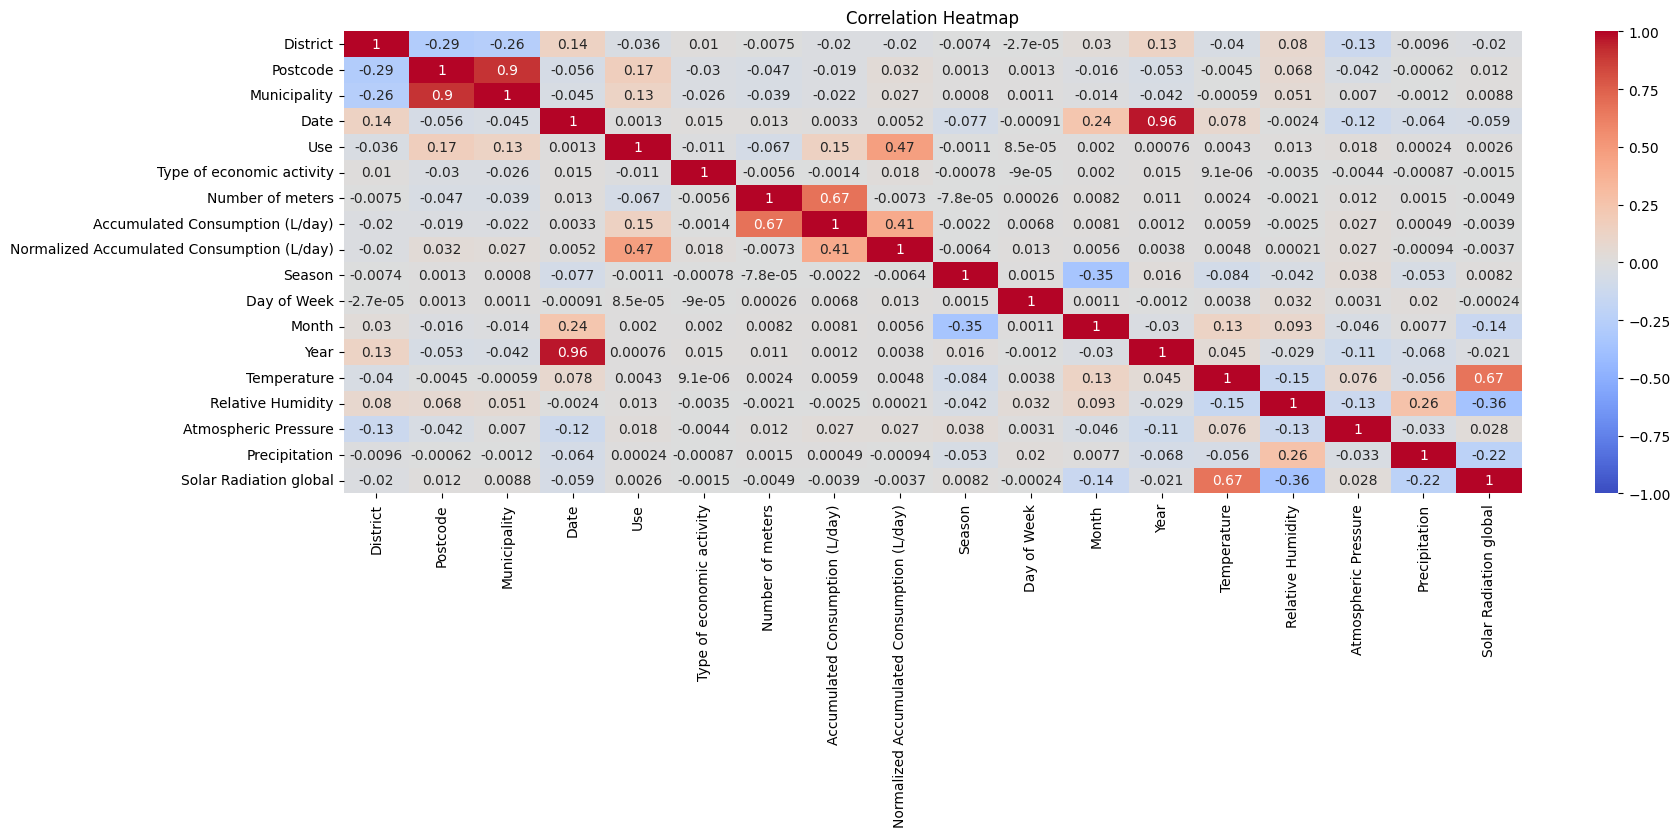

In [41]:
# We remove the null values in to see the correct correlation of the data
dataset_1_act_eco_filtered = dataset_1_act_eco_filtered.dropna(subset = ['District'])
dataset_1_act_eco_filtered = dataset_1_act_eco_filtered.dropna(subset = ['Temperature'])
dataset_1_act_eco_filtered = dataset_1_act_eco_filtered.dropna(subset = ['Relative Humidity'])
dataset_1_act_eco_filtered = dataset_1_act_eco_filtered.dropna(subset = ['Atmospheric Pressure'])
dataset_1_act_eco_filtered = dataset_1_act_eco_filtered.dropna(subset = ['Precipitation'])
dataset_1_act_eco_filtered = dataset_1_act_eco_filtered.dropna(subset = ['Solar Radiation global'])

dataset_filtered_not_null = dataset_1_act_eco_filtered[~dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].isnull()]
corr = dataset_filtered_not_null.corr()
plt.figure(figsize=(19,6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12})
plt.show()

##### **4.1. Linear Regression**

In [46]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Independent variables
features = ['District','Postcode','Municipality','Date','Use','Type of economic activity','Number of meters','Season','Day of Week',
            'Month','Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset_1_act_eco_filtered2[features]

# Target variable (dependent variable)
y = dataset_1_act_eco_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 12344242
Length y_train: 12344242
Lenght X_test: 3086061
Length y_test: 3086061


In [47]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evalute the model
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error (MSE): {round(np.sqrt(mse_lr), 4)}")
print(f"Linear Regression Mean Absolute Error (MAE): {round(mae_lr, 4)}")
print(f"Linear Regression R-squared (R2): {round(r2_lr, 4)}")

Linear Regression Mean Squared Error (MSE): 2236.9065
Linear Regression Mean Absolute Error (MAE): 590.5723
Linear Regression R-squared (R2): 0.4897


##### **4.2. Random Forest**

In [48]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset1_filtered2) // 100
dataset1_filtered2 = dataset1_filtered2.sample(n=rows, random_state=42)

# Independent variables
features = ['District','Postcode','Municipality','Date','Use','Type of economic activity','Number of meters','Season','Day of Week',
            'Month','Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 123442
Length y_train: 123442
Lenght X_test: 30861
Length y_test: 30861


In [49]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE):", round(np.sqrt(mse_rf), 4))
print(f"Random Forest Mean Absolute Error (MAE): {round(mae_rf, 4)}")
print(f"Random Forest R-squared (R2):", round(r2_rf, 4))

Random Forest Mean Squared Error (MSE): 1561.8
Random Forest Mean Absolute Error (MAE): 426.5362
Random Forest R-squared (R2): 0.7546


##### **4.3. XGBoost**

In [43]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Independent variables
features = ['District','Postcode','Municipality','Date','Use','Type of economic activity','Number of meters','Season','Day of Week',
            'Month','Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radiation global']

X = dataset_1_act_eco_filtered2[features]

# Target variable (dependent variable)
y = dataset_1_act_eco_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 12344242
Length y_train: 12344242
Lenght X_test: 3086061
Length y_test: 3086061


In [44]:
# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error (MSE):", round(np.sqrt(mse_xgb), 4))
print(f"XGBoost Mean Absolute Error (MAE): {round(mae_xgb, 4)}")
print(f"XGBoost R-squared (R2):", round(r2_xgb, 4))

XGBoost Mean Squared Error (MSE): 1111.9765
XGBoost Mean Absolute Error (MAE): 364.271
XGBoost R-squared (R2): 0.8739


##### **4.4. K-Nearest Neighbors**

In [40]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset1_filtered2) // 10
dataset1_filtered2 = dataset1_filtered2.sample(n=rows, random_state=42)

# Independent variables
features = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 1234424
Length y_train: 1234424
Lenght X_test: 308606
Length y_test: 308606


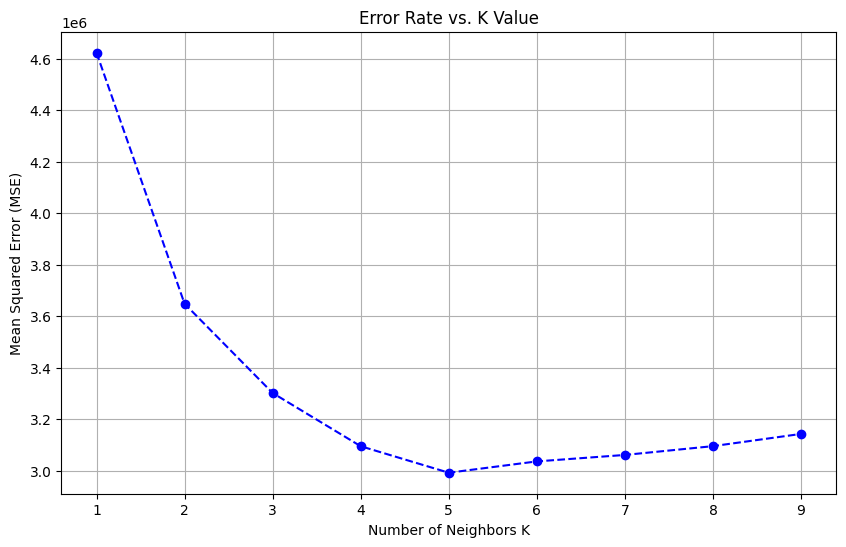

The best k value is: 5


In [86]:
# Range of k values to test
k_values = range(1, 10)
mse_values = []

# Evaluation of the model for each k value
for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_knn)
    mse_values.append(mse)

# Plot error rates vs k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o', linestyle='dashed', color='b')
plt.xlabel('Number of Neighbors K', fontsize=10)
plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
plt.title('Error Rate vs. K Value', fontsize=12)
plt.xticks(k_values)
plt.grid(True)
plt.show()

# k value with the minimum error rate
best_k = k_values[np.argmin(mse_values)]
print(f"The best k value is: {best_k}")

In [41]:
# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"K-Nearest Neighbors Mean Squared Error (MSE):", round(np.sqrt(mse_knn), 4))
print(f"K-Nearest Neighbors Mean Absolute Error (MAE): {round(mae_knn, 4)}")
print(f"K-Nearest Neighbors R-squared (R2):", round(r2_knn, 4))

K-Nearest Neighbors Mean Squared Error (MSE): 1586.0636
K-Nearest Neighbors Mean Absolute Error (MAE): 481.4248
K-Nearest Neighbors R-squared (R2): 0.7322


##### **4.5. Support Vector Machine**

In [46]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset1_filtered2) // 100
dataset1_filtered2 = dataset1_filtered2.sample(n=rows, random_state=42)

# Independent variables
features = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 123442
Length y_train: 123442
Lenght X_test: 30861
Length y_test: 30861


In [47]:
# Support Vector Machine
svm_model = SVR()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"Support Vector Machine Mean Squared Error (MSE):", round(np.sqrt(mse_svm), 4))
print(f"Support Vector Machine Mean Absolute Error (MAE): {round(mae_svm, 4)}")
print(f"Support Vector Machine R-squared (R2):", round(r2_svm, 4))

Support Vector Machine Mean Squared Error (MSE): 3203.6143
Support Vector Machine Mean Absolute Error (MAE): 652.1425
Support Vector Machine R-squared (R2): -0.0327


##### **4.6. Explainability**

In [ ]:
# Convert the data to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

# We use a small subset of the training data to initialize the SHAP KernelExplainer
background = shap.kmeans(X_train_array, 10)
explainer = shap.KernelExplainer(knn_model.predict, background)

In [ ]:
# We compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_array)

In [ ]:
# Convert shap_values to Explanation objects
shap_values_exp = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test_array, feature_names=features)

# Visualize SHAP values
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, X_test)

##### **4.7. Conclusions on Data Prediction Algorithms**

Based on the R-squared values obtained per each model I conclude that XGBoost with a 0.8739 is the most accurate for dataset1_v2.csv data. It is considered a good model if the R-squared value is higher than 0.9. Therefore now we will replace the missing values with the predictions of this model. We have already trained model so now we replace all null values.

In [46]:
# Identifiquem les files amb valor Null en 'Normalized Consum acumulat (L/dia)'
missing_rows = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].isnull()]

features2 = ['District','Postcode','Municipality','Date','Use','Type of economic activity','Number of meters','Season','Day of Week',
            'Month','Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radiation global']
X_ = missing_rows[features2]

# Predim els valors amb el model
predicted_values = xgb_model.predict(X_)

dataset_1_act_eco_filtered.loc[missing_rows.index, 'Accumulated Consumption (L/day)'] = predicted_values

We now check that no null values nor negatives are in the dataset.

In [47]:
# Number of null values in Accumulated Consumption (L/day)
print("Number of Nulls in the dataset:", dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].isnull().sum())

# Number of negatives values in Accumulated Consumption (L/day)
print("Number of Negatives in the dataset:", len(dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'] < 0]))

Number of Nulls in the dataset: 0
Number of Negatives in the dataset: 21125


We replace the few negative predicted values by 0.

In [48]:
# Replace negative values with 0
dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'] = dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].apply(lambda x: max(x, 0))

In [50]:
# Number of null values in Consumption (L/h)
print("Number of Nulls in the dataset:", dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].isnull().sum())

# Number of negatives values in Consumption (L/h)
print("Number of Negatives in the dataset:", len(dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'] < 0]))

Number of Nulls in the dataset: 0
Number of Negatives in the dataset: 0


In order to keep working with our normalized values lets once again put all null values in 'Normalized Accumulated Consumption (L/day)' by diving the consumption by the number of meters.

In [51]:
predicted_values = dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'] / dataset_1_act_eco_filtered['Number of meters']

dataset_1_act_eco_filtered.loc[dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull(), 'Normalized Accumulated Consumption (L/day)'] = predicted_values

In [52]:
# Number of null values in Normalized Accumulated Consumption (L/day)
print("Number of Nulls in the dataset:", dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull().sum())

# Number of negatives values in Normalized Accumulated Consumption (L/day)
print("Number of Negatives in the dataset:", len(dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'] < 0]))

Number of Nulls in the dataset: 0
Number of Negatives in the dataset: 0


Lets visualize the Consumption after having cleaned and projected the incorrect values.

In [53]:
# To reverse the encoding
dataset_1_act_eco_filtered['Municipality'] = le_municipality.inverse_transform(dataset_1_act_eco_filtered['Municipality'])
dataset_1_act_eco_filtered['Date'] = le_date.inverse_transform(dataset_1_act_eco_filtered['Date'])
dataset_1_act_eco_filtered['Use'] = le_use.inverse_transform(dataset_1_act_eco_filtered['Use'])
dataset_1_act_eco_filtered['Type of economic activity'] = le_typeofeco.inverse_transform(dataset_1_act_eco_filtered['Type of economic activity'])
dataset_1_act_eco_filtered['Season'] = le_season.inverse_transform(dataset_1_act_eco_filtered['Season'])
dataset_1_act_eco_filtered['Day of Week'] = le_dayofweek.inverse_transform(dataset_1_act_eco_filtered['Day of Week'])
dataset_1_act_eco_filtered.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year,Temperature,Relative Humidity,Atmospheric Pressure,Precipitation,Solar Radiation global
7379,1.0,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,* Altres articles de cautxú n.c.a.a./ * Otros ...,1,19.0,19.000,Winter,Tuesday,1,2019,9.4125,75.041667,979.635417,0.0,94.75
7380,1.0,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,* Altres articles de consum durable n.c.a.a./ ...,1,0.0,0.000,Winter,Tuesday,1,2019,9.4125,75.041667,979.635417,0.0,94.75
7381,1.0,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,"* Altres productes alimentaris, gelats, etc./ ...",2,1.0,0.500,Winter,Tuesday,1,2019,9.4125,75.041667,979.635417,0.0,94.75
7382,1.0,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,* Altres productes inter-industrials (excepte/...,7,304.0,43.429,Winter,Tuesday,1,2019,9.4125,75.041667,979.635417,0.0,94.75
7383,1.0,8850,GAVA,2019-01-01,Industrial/Industrial/Industrial,* Altres serveis d'alimentació propis de la re...,2,148.0,74.000,Winter,Tuesday,1,2019,9.4125,75.041667,979.635417,0.0,94.75


##### **4.8. Exploratory Data Analysis**

In [ ]:
# Null values per column
columns_dataset1 = dataset_1_act_eco_filtered.columns
for column in columns_dataset1:
  print("Column:", column, "- Null values: ", dataset_1_act_eco_filtered[column].isnull().sum())

In [ ]:
# Define the type of plot for each column based on the data type
plot_types = {}
# columns = [x for x in df.columns if x not in ["car", "model"]]
columns = [x for x in dataset_1_act_eco_filtered.columns if x not in ["Type of economic activity"]]

for col in columns:
    if dataset_1_act_eco_filtered[col].dtype == 'object':  # Categorical columns
        plot_types[col] = 'bar'
    else:
        unique_values = dataset_1_act_eco_filtered[col].nunique()
        if unique_values < 10:  # Discrete columns
            plot_types[col] = 'bar'
        else:  # Continuous columns
            plot_types[col] = 'kde'

n_cols = 3
n_rows = (len(columns) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Plot each column in the dataframe
for i, col in enumerate(columns):
    ax = axes[i]
    if plot_types[col] == 'bar':
        # For categorical and discrete data, use a count plot (bar chart)
        sns.countplot(x=col, data=dataset_1_act_eco_filtered, ax=ax)
        ax.set_title(f'Count Plot of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Counts')
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    else:
        # For continuous data, use a density plot
        sns.kdeplot(dataset_1_act_eco_filtered[col], ax=ax, fill=True)
        ax.set_title(f'Density Plot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

- Seasonal Analysis

In [ ]:
# Distribution of normalized vs non normalized
df_sorted = dataset_1_act_eco_filtered.sort_values(by='Date')
plt.figure(figsize=(10, 5))
plt.scatter(df_sorted["Date"], df_sorted["Normalized Accumulated Consumption (L/day)"], color='lightskyblue',  marker='o', s=20, alpha=0.7, label='Normalized Accumulated Consumption')
plt.title("Distribution of Normalized Accumulated Consumption over Time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Normalized Accumulated Consumption (L/day)", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.show()

In [ ]:
# Distribution of normalized vs non normalized
df_sorted = dataset_1_act_eco_filtered.sort_values(by='Date')
plt.figure(figsize=(10, 5))
plt.scatter(df_sorted["Date"], df_sorted["Accumulated Consumption (L/day)"], color='blue',  marker='o', s=20, alpha=0.7, label='Accumulated Consumption')
plt.title("Distribution of Accumulated Consumption over Time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Accumulated Consumption (L/day)", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.show()

In [ ]:
# Distribution of normalized vs non normalized
df_sorted = dataset_1_act_eco_filtered.sort_values(by='Date')
plt.figure(figsize=(10, 5))
plt.scatter(df_sorted["Date"], df_sorted["Accumulated Consumption (L/day)"], color='blue',  marker='o', s=20, alpha=0.7, label='Accumulated Consumption')
plt.scatter(df_sorted["Date"], df_sorted["Normalized Accumulated Consumption (L/day)"], color='lightskyblue',  marker='o', s=20, alpha=0.7, label='Normalized Accumulated Consumption')
plt.title("Distribution of Accumulated Consumption vs Normalized Accumulated Consumption over Time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Accumulated Consumption (L/day)", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.show()

In [ ]:
use_cases = ['Domèstic/Doméstico/Domestic', 'Comercial/Comercial/Commercial', 'Industrial/Industrial/Industrial']
num_plots = len(use_cases)
num_columns = 3
num_rows = int(np.ceil(num_plots / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 6))
axes = axes.flatten()

for i, use_case in enumerate(use_cases):
    iteration_dataset = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Use'] == use_case].copy()
    sns.violinplot(data=iteration_dataset, x='Season', y='Normalized Accumulated Consumption (L/day)', hue='Season', ax=axes[i], palette={'Spring': '#2ca02c',  'Summer': '#ff7f0e',  'Autumn': '#d62728',  'Winter': '#1f77b4'}, legend=False)
    axes[i].set_title(f'Seasonal Variations in Normalized Consumption for {use_case}', fontsize=10)
    axes[i].set_xlabel('Season', fontsize=10)
    axes[i].set_ylabel('Normalized Accumulated Consumption (L/day)', fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Hide any unused subplots if the number of use cases is not a multiple of num_columns
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

fig.suptitle('Seasonal Variations in Normalized Consumption', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Normalized Consumption Per Year Scatter Plot
df_sorted = dataset_1_act_eco_filtered.sort_values(by='Date')

use_cases = ['Domèstic/Doméstico/Domestic', 'Comercial/Comercial/Commercial', 'Industrial/Industrial/Industrial']
num_plots = len(use_cases)
num_columns = 1
num_rows = 3

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 6))
axes = axes.flatten()

for i, use_case in enumerate(use_cases):
    iteration_dataset = df_sorted[df_sorted['Use'] == use_case].copy()

    df_2019 = iteration_dataset[iteration_dataset['Year'] == 2019]
    df_2019 = df_2019.groupby(['Date', 'Use'])['Normalized Accumulated Consumption (L/day)'].mean().reset_index()

    df_2020 = iteration_dataset[iteration_dataset['Year'] == 2020]
    df_2020 = df_2020.groupby(['Date', 'Use'])['Normalized Accumulated Consumption (L/day)'].mean().reset_index()

    df_2021 = iteration_dataset[iteration_dataset['Year'] == 2021]
    df_2021 = df_2021.groupby(['Date', 'Use'])['Normalized Accumulated Consumption (L/day)'].mean().reset_index()

    df_2022 = iteration_dataset[iteration_dataset['Year'] == 2022]
    df_2022 = df_2022.groupby(['Date', 'Use'])['Normalized Accumulated Consumption (L/day)'].mean().reset_index()

    axes[i].scatter(df_2019["Date"], df_2019["Normalized Accumulated Consumption (L/day)"], color='limegreen',  marker='o', s=20, alpha=0.7, label='2019')
    axes[i].scatter(df_2020["Date"], df_2020["Normalized Accumulated Consumption (L/day)"], color='cornflowerblue',  marker='o', s=20, alpha=0.7, label='2020')
    axes[i].scatter(df_2021["Date"], df_2021["Normalized Accumulated Consumption (L/day)"], color='orange',  marker='o', s=20, alpha=0.7, label='2021')
    axes[i].scatter(df_2022["Date"], df_2022["Normalized Accumulated Consumption (L/day)"], color='tomato',  marker='o', s=20, alpha=0.7, label='2022')
    
    axes[i].set_title(f'Distribution of Normalized Accumulated Consumption over Time per Years for {use_case}', fontsize=10)
    axes[i].set_xlabel("Date", fontsize=10)
    axes[i].set_ylabel("Normalized Accumulated Consumption (L/day)", fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Hide any unused subplots if the number of use cases is not a multiple of num_columns
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Normalized Accumulated Consumption over Time per Years", fontsize=12)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.tight_layout()
plt.show()

- Single day analysis

In [ ]:
use_cases = ['Domèstic/Doméstico/Domestic', 'Comercial/Comercial/Commercial', 'Industrial/Industrial/Industrial']
num_plots = len(use_cases)
num_columns = 1
num_rows = 3

fig, axes = plt.subplots(num_rows, num_columns, figsize=(17, num_rows * 6))
axes = axes.flatten()

for i, use_case in enumerate(use_cases):
    iteration_dataset = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Use'] == use_case].copy()

    df_monday = iteration_dataset[iteration_dataset['Day of Week'] == 'Monday']
    df_tuesday = iteration_dataset[iteration_dataset['Day of Week'] == 'Tuesday']
    df_wednesday = iteration_dataset[iteration_dataset['Day of Week'] == 'Wednesday']
    df_thursday = iteration_dataset[iteration_dataset['Day of Week'] == 'Thursday']
    df_friday = iteration_dataset[iteration_dataset['Day of Week'] == 'Friday']
    df_saturday = iteration_dataset[iteration_dataset['Day of Week'] == 'Saturday']
    df_sunday = iteration_dataset[iteration_dataset['Day of Week'] == 'Sunday']

    sns.kdeplot(df_monday['Normalized Accumulated Consumption (L/day)'], label='Monday', ax=axes[i], fill=True, color='#F9DC5C')
    sns.kdeplot(df_tuesday['Normalized Accumulated Consumption (L/day)'], label='Tuesday', ax=axes[i], fill=True, color='#FF8360')
    sns.kdeplot(df_wednesday['Normalized Accumulated Consumption (L/day)'], label='Wednesday', ax=axes[i], fill=True, color='#FE5F55')
    sns.kdeplot(df_thursday['Normalized Accumulated Consumption (L/day)'], label='Thursday', ax=axes[i], fill=True, color='#EE85B5')
    sns.kdeplot(df_friday['Normalized Accumulated Consumption (L/day)'], label='Friday', ax=axes[i], fill=True, color='#A663CC')
    sns.kdeplot(df_saturday['Normalized Accumulated Consumption (L/day)'], label='Saturday', ax=axes[i], fill=True, color='#87F1FF')
    sns.kdeplot(df_sunday['Normalized Accumulated Consumption (L/day)'], label='Sunday', ax=axes[i], fill=True, color='#A1C084') 

    axes[i].set_title(f' Weekly Normalized Consumption for {use_case}', fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].legend(loc='upper right')

# Hide any unused subplots if the number of use cases is not a multiple of num_columns
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

fig.suptitle('Weekly Normalized Consumption', fontsize=14)
plt.tight_layout()
plt.legend()
plt.show()

- Geographical Analysis

In [ ]:
# District names dictionary
district_names = {
    1.0: "Ciutat Vella",
    2.0: "Eixample",
    3.0: "Sants-Montjuïc",
    4.0: "Les Corts",
    5.0: "Sarrià-Sant Gervasi",
    6.0: "Gràcia",
    7.0: "Horta-Guinardó",
    8.0: "Nou Barris",
    9.0: "Sant Andreu",
    10.0: "Sant Martí"
}

# Add a column for district names
dataset_1_act_eco_filtered['District Name'] = dataset_1_act_eco_filtered['District'].map(district_names)

# Filter data for each year
df_2019 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2019]
df_2020 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2020]
df_2021 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2021]
df_2022 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2022]

# List of filtered dataframes for easy iteration
dfs = [df_2019, df_2020, df_2021, df_2022]
years = [2019, 2020, 2021, 2022]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
palette = sns.color_palette("tab10", len(district_names))

# Plot data for each year
for i, (df, year) in enumerate(zip(dfs, years)):
    total_consumption_per_district = df.groupby('District Name')['Normalized Accumulated Consumption (L/day)'].sum()
    total_consumption_per_district.plot(kind='bar', ax=axes[i], color=palette)
    axes[i].set_title(f'Total Normalized Consumption Per District in {year}', fontsize=15)
    axes[i].set_xlabel('District', fontsize=12)
    axes[i].set_ylabel('Total Normalized Accumulated Consumption (L/day)', fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10, rotation=45)
    axes[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# District names dictionary
district_names = {
    1.0: "Ciutat Vella",
    2.0: "Eixample",
    3.0: "Sants-Montjuïc",
    4.0: "Les Corts",
    5.0: "Sarrià-Sant Gervasi",
    6.0: "Gràcia",
    7.0: "Horta-Guinardó",
    8.0: "Nou Barris",
    9.0: "Sant Andreu",
    10.0: "Sant Martí"
}

# Use case names
use_cases = ['Domèstic/Doméstico/Domestic', 'Comercial/Comercial/Commercial', 'Industrial/Industrial/Industrial']

# Add a column for district names
dataset_1_act_eco_filtered['District Name'] = dataset_1_act_eco_filtered['District'].map(district_names)

# Create a color palette
palette = sns.color_palette("tab10", len(district_names))

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
axes = axes.flatten()

# Plot data for each use case
for i, use_case in enumerate(use_cases):
    df_use_case = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Use'] == use_case]
    total_consumption_per_district = df_use_case.groupby('District Name')['Normalized Accumulated Consumption (L/day)'].sum()
    total_consumption_per_district.plot(kind='bar', ax=axes[i], color=palette)
    axes[i].set_title(f'Total Normalized Consumption Per District for {use_case}', fontsize=15)
    axes[i].set_xlabel('District', fontsize=12)
    axes[i].set_ylabel('Total Normalized Accumulated Consumption (L/day)', fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10, rotation=45)
    axes[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Filter data for each year
df_2019 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2019]
df_2020 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2020]
df_2021 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2021]
df_2022 = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Year'] == 2022]

# List of filtered dataframes for easy iteration
dfs = [df_2019, df_2020, df_2021, df_2022]
years = [2019, 2020, 2021, 2022]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
palette = sns.color_palette("tab10", 6)

# Plot data for each year
for i, (df, year) in enumerate(zip(dfs, years)):
    total_consumption_per_municipality = df.groupby('Municipality')['Normalized Accumulated Consumption (L/day)'].sum()
    total_consumption_per_municipality.plot(kind='bar', ax=axes[i], color=palette)
    axes[i].set_title(f'Total Normalized Consumption Per Municipality in {year}', fontsize=15)
    axes[i].set_xlabel('Municipality', fontsize=12)
    axes[i].set_ylabel('Total Normalized Accumulated Consumption (L/day)', fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10, rotation=45)
    axes[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

## 5. Analysis of anomalies

##### **5.1. Classification Criteria**

Previously, we stored all anomalies for later analysis. We are now going to state a classification criteria in order to classify said anomalies into 3 categories: leak or waste, system error or correct but misclassified.
This classification is based on the average of the correct real data, I'm not using the predicted one by the models but it might not be very accurate. This should be done with specific data portraying leaks, waste and system errors.

In [33]:
# % of anomalies with respect to the original dataset
percentage = (2373293 / 20495388 ) * 100
print("% of anomalies with respect to the original dataset: ", round(percentage, 2), "%")

% of anomalies with respect to the original dataset:  11.58 %


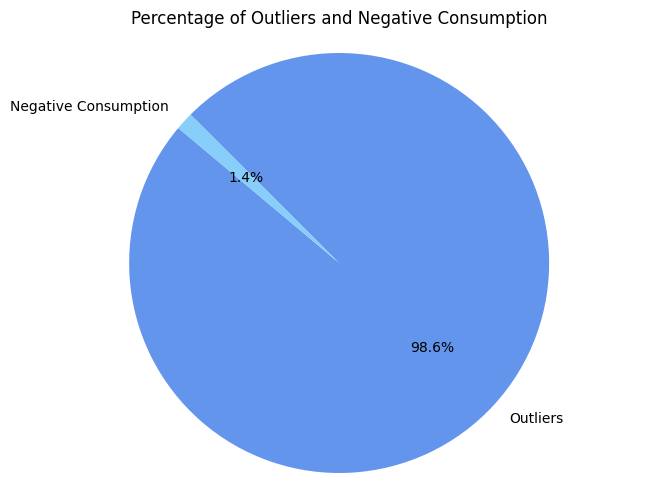

In [23]:
# Count of Outliers and Negative values
outliers_count = (anomalies['Normalized Accumulated Consumption (L/day)'] > 0).sum()
negative_count = (anomalies['Normalized Accumulated Consumption (L/day)'] < 0).sum()

total_count = len(anomalies)
outliers_percentage = (outliers_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

labels = ['Outliers', 'Negative Consumption']
sizes = [outliers_percentage, negative_percentage]
colors = ['cornflowerblue', 'lightskyblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Outliers and Negative Consumption')
plt.axis('equal')
plt.show()

Now we compute the minimum, average and maximum values per type of Use so we can classify each values accordingly.

In [27]:
# For each type of Use we can compute the min, average and max values
grouped_data = clean_data.groupby('Use')['Normalized Accumulated Consumption (L/day)'].agg(['min', 'mean', 'max'])

# Accessing min, average, and max values for a specific 'Use' type
use_type = 'Comercial/Comercial/Commercial'
commercial_min = grouped_data.loc[use_type, 'min']
commercial_average = grouped_data.loc[use_type, 'mean']
commercial_max = grouped_data.loc[use_type, 'max']

use_type = 'Industrial/Industrial/Industrial'
industrial_min = grouped_data.loc[use_type, 'min']
industrial_average = grouped_data.loc[use_type, 'mean']
industrial_max = grouped_data.loc[use_type, 'max']

grouped_data

,min,mean,max
Use,,,
Comercial/Comercial/Commercial,0.0,96.367193,476.75
Industrial/Industrial/Industrial,0.0,928.889779,7197.00


##### **5.2. Anomalies classification**

The following function gets the anomalies dataset and depending on the type of Use applies a classification. I considered consumption values over the maximum value to be of type 'Leak or Waste'. If the consumption is negative then I consider this a 'Data Collection System Error' and in case of not belonging in any of these two groups then the value would be 'Correct but Misclassified'.

In [28]:
def anomalies_classification(dataset_anomalies):        
    if dataset_anomalies['Use'] == 'Comercial/Comercial/Commercial':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > commercial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
        
    elif dataset_anomalies['Use'] == 'Industrial/Industrial/Industrial':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > industrial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
    

anomalies['Classification'] = anomalies.apply(anomalies_classification, axis=1)
anomalies.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Classification
0,NaN,8001,BARCELONA,2021-05-31,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0,Data Collection System Error
1,NaN,8001,BARCELONA,2021-07-18,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0,Data Collection System Error
2,NaN,8001,BARCELONA,2021-07-20,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0,Data Collection System Error
3,NaN,8001,BARCELONA,2021-07-30,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0,Data Collection System Error
4,NaN,8001,BARCELONA,2021-08-09,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0,Data Collection System Error


Now we can visualize the new classification in total and per type of Use.

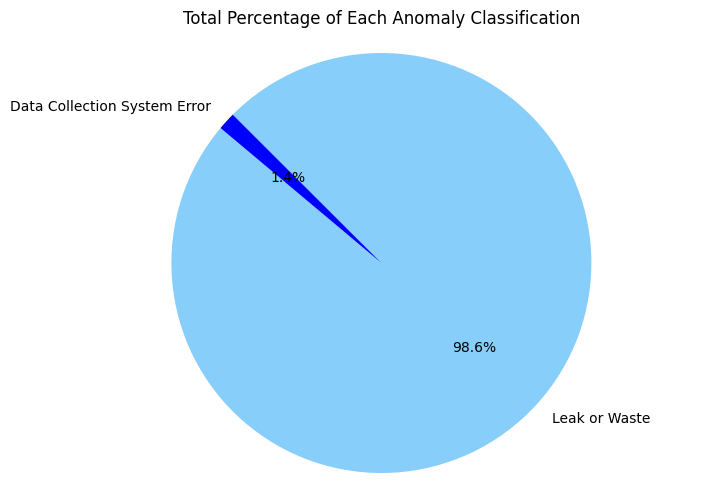

In [29]:
# Count occurrences of each classification
classification_counts = anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Total Percentage of Each Anomaly Classification')
plt.axis('equal')
plt.show()

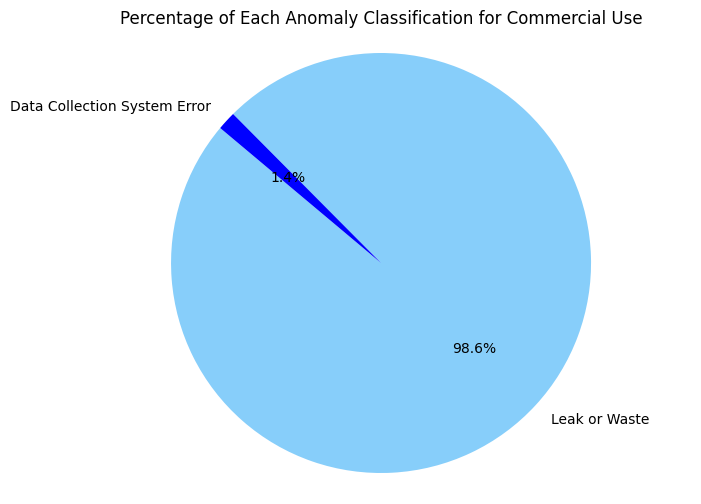

In [30]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Comercial/Comercial/Commercial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for Commercial Use')
plt.axis('equal') 
plt.show()

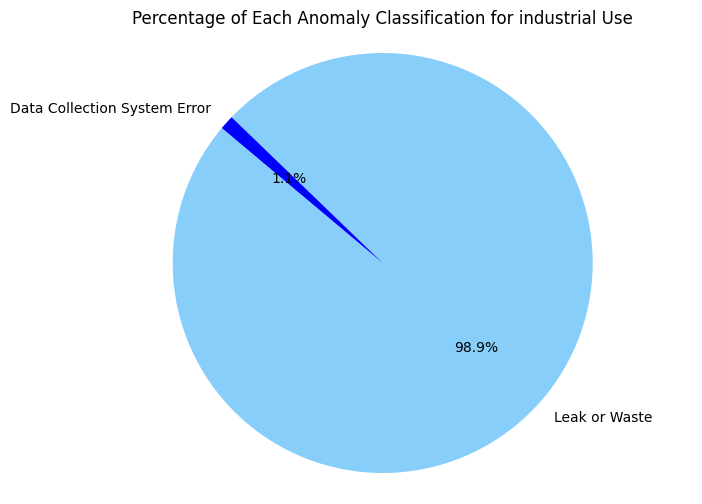

In [31]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Industrial/Industrial/Industrial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for industrial Use')
plt.axis('equal')
plt.show()

In [ ]:
# Download anomalies
anomalies.to_csv('anomalies_dataset1_activitat_eco_v2.csv', index=False)

## 6. Export improved data

In [ ]:
dataset_1_act_eco_filtered.to_csv('updated_dataset_1_activitat_eco_v2.csv', index=False)